In [1]:
print('STOCK PREDICTION USING RNN LSTM')
import numpy as np
import pandas as pd
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = 'rs%.0f'
tick = mtick.FormatStrFormatter(fmt)

%matplotlib inline


STOCK PREDICTION USING RNN LSTM


Using TensorFlow backend.


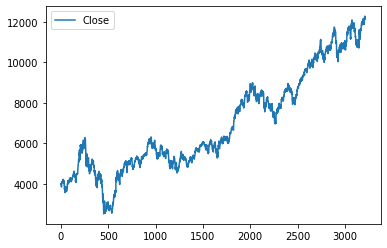

<Figure size 432x288 with 0 Axes>

In [2]:
data_csv = pd.read_csv('/nifty_complete.csv')

data_csv[['Close']].plot()
plt.show()
plt.clf()

In [3]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data_csv)-1))

# 90% of data will be of training
train_end = int(data_to_use*0.85)

total_data = len(data_csv)
print("total_data:", total_data)

total_data: 3216


In [4]:
start = total_data - data_to_use

# Currently doing prediction only for 1 step ahead
steps_to_predict = 1

# order - Date 1 	compound 2	neg 3	neu 4	pos 5	Open 6 	High 7 	Low 8	Close 9	Volume 10
# req order - close, compund, neg, neu, pos, open, high, low, volume
# Order -> 8,1,2,3,4,5,6,7,9
yt = data_csv.iloc[start:total_data,9] #close
yt1 = data_csv.iloc[start:total_data,2] #compund
yt2 = data_csv.iloc[start:total_data,3] #neg
yt3 = data_csv.iloc[start:total_data,4] #neu
yt4 = data_csv.iloc[start:total_data,5] #pos
yt5 = data_csv.iloc[start:total_data,6] #open
yt6 = data_csv.iloc[start:total_data,7] #high
yt7 = data_csv.iloc[start:total_data,8] #low
vt = data_csv.iloc[start:total_data,10] #volume

print("yt head (close) :")
print(yt.head())

yt head (close) :
1    4024.05
2    3988.80
3    3983.40
4    3933.40
5    3911.40
Name: Close, dtype: float64


In [5]:
#shift next day close and next day compund
yt_ = yt.shift(-1) #shifted close
yt1_ = yt1.shift(-1) #shifted compund

#taking only: close, next_close, compund, next_compund, volume, open, high, low
data = pd.concat([yt, yt_, yt1, yt1_, vt, yt5, yt6, yt7], axis=1)
data.columns = ['yt', 'yt_', 'yt1', 'yt1_','vt', 'yt5', 'yt6', 'yt7']

data = data.dropna()
     
print(data[:10])

         yt      yt_     yt1    yt1_        vt      yt5      yt6      yt7
1   4024.05  3988.80 -0.3111  0.1280  63826475  4007.70  4029.80  3985.00
2   3988.80  3983.40  0.1280 -0.9110  67096186  4027.30  4041.00  3979.80
3   3983.40  3933.40 -0.9110  0.9815  69146575  3990.15  4011.45  3969.65
4   3933.40  3911.40  0.9815  0.9735  63615668  3983.30  3987.45  3913.00
5   3911.40  3850.30  0.9735  0.9962  65321592  3933.30  3963.75  3890.75
6   3850.30  3942.25  0.9962  0.9644  68470689  3910.95  3911.95  3841.70
7   3942.25  4052.45  0.9644  0.9549  83152375  3852.15  3953.10  3833.60
8   4052.45  4078.40  0.9549  0.9761  81362992  3944.55  4059.15  3944.55
9   4078.40  4080.50  0.9761  0.9955  81723925  4052.85  4099.65  4052.40
10  4080.50  4076.45  0.9955  0.9931  60251260  4090.70  4107.45  4067.90


In [6]:
# target variable - closed price
# after shifting
y = data['yt_'] #next_close

# close, compund, next_compund, volume, open, high, low   
cols = ['yt', 'yt1', 'yt1_', 'vt', 'yt5', 'yt6', 'yt7']
x = data[cols]

In [7]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

In [8]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

In [9]:
batch_size = 32
nb_epoch = 100
neurons = 25
dropout = 0.1

seed = 2016
np.random.seed(seed)

model = Sequential ()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', inner_activation='hard_sigmoid', input_shape=(len(cols), 1)))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True,  activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))
model.add(Activation('tanh'))

print(model.summary())

model.compile(loss='mean_squared_error' , optimizer='RMSprop')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(25, return_sequences=True, activation="tanh", input_shape=(7, 1), recurrent_activation="hard_sigmoid")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activity_regularizer=<keras.reg..., activation="linear", units=1)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 25)             2700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 25)             5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [10]:
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
print("in train MSE = ", round( score_train ,4)) 
print("in test MSE = ", score_test )

481/481 [==============================] - 1s 2ms/step
in train MSE =  0.0015
in test MSE =  0.046930411809246037


In [11]:
pred = model.predict(X_test) 
pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))

prediction_data = pred[-1]     

print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

print ("actual data")
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
print (X_test)
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len( y_test), 1)))

Inputs: (None, 7, 1)
Outputs: (None, 1)
Actual input: (481, 7, 1)
Actual output: (481, 1)
prediction data:
[10520.95]
actual data
[[1.068125e+04 9.997000e-01 9.996000e-01 ... 1.068255e+04 1.069040e+04
  1.059710e+04]
 [1.074155e+04 9.996000e-01 9.974000e-01 ... 1.071850e+04 1.078265e+04
  1.071380e+04]
 [1.070045e+04 9.974000e-01 9.996000e-01 ... 1.076150e+04 1.076235e+04
  1.068785e+04]
 ...
 [1.212655e+04 9.991000e-01 9.997000e-01 ... 1.221185e+04 1.222155e+04
  1.211885e+04]
 [1.224580e+04 9.997000e-01 9.976000e-01 ... 1.217290e+04 1.225845e+04
  1.215790e+04]
 [1.225585e+04 9.976000e-01 9.997000e-01 ... 1.227490e+04 1.228645e+04
  1.221380e+04]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


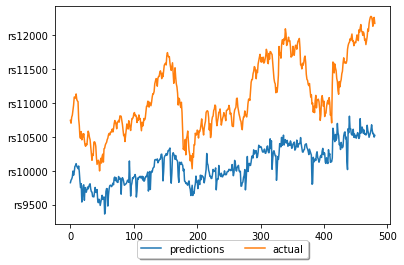

<Figure size 432x288 with 0 Axes>

In [12]:
'''Plotting'''
plt.plot(pred, label="predictions")
plt.plot([row[0] for row in y_test], label="actual")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

ax = plt.axes()
ax.yaxis.set_major_formatter(tick)

plt.show()
plt.clf()

480
53.541666666666664


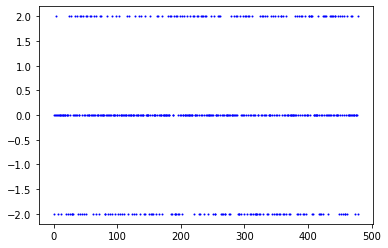

<Figure size 432x288 with 0 Axes>

In [13]:
def getSlope(data):
  incdec = []
  for i in range(len(data)-1):
    if(data[i+1]-data[i] < 0):
      incdec += [-1]
    else:
      incdec += [1]
  return incdec

pslope=getSlope([i[0] for i in pred])
# for i in range(len(pslope))53.541666666666664:
#   plt.scatter(i,pslope[i],label="predictions",color='r')
aslope=getSlope([row[0] for row in y_test])

eq = 0
for i in range(len(aslope)):
  plt.scatter(i,aslope[i]-pslope[i],s=1,label="actual",color='b')
  if(aslope[i]-pslope[i]==0):
    eq+=1
print(len(aslope))
print(eq / len(aslope) * 100)


plt.show()
plt.clf()
